Loading DistilBERT model...

Sentence: I saw a move in Apple phone where an apple fell on Newton's head

Tokens: ['[CLS]', 'i', 'saw', 'a', 'move', 'in', 'apple', 'phone', 'where', 'an', 'apple', 'fell', 'on', 'newton', "'", 's', 'head', '[SEP]']

Number of attention heads: 12
Number of layers: 6
Sequence length: 18

Original tokens: ['[CLS]', 'i', 'saw', 'a', 'move', 'in', 'apple', 'phone', 'where', 'an', 'apple', 'fell', 'on', 'newton', "'", 's', 'head', '[SEP]']
Filtered tokens (removed [CLS] and [SEP]): ['i', 'saw', 'a', 'move', 'in', 'apple', 'phone', 'where', 'an', 'apple', 'fell', 'on', 'newton', "'", 's', 'head']

'Apple' (company) found at index 5: apple
'apple' (fruit) found at index 9: apple
Attention matrix shape after filtering: (16, 16)
Each row sums to approximately 1.0: [1.0000001 1.        1.       ]


Visualization saved as 'attention_analysis.png'


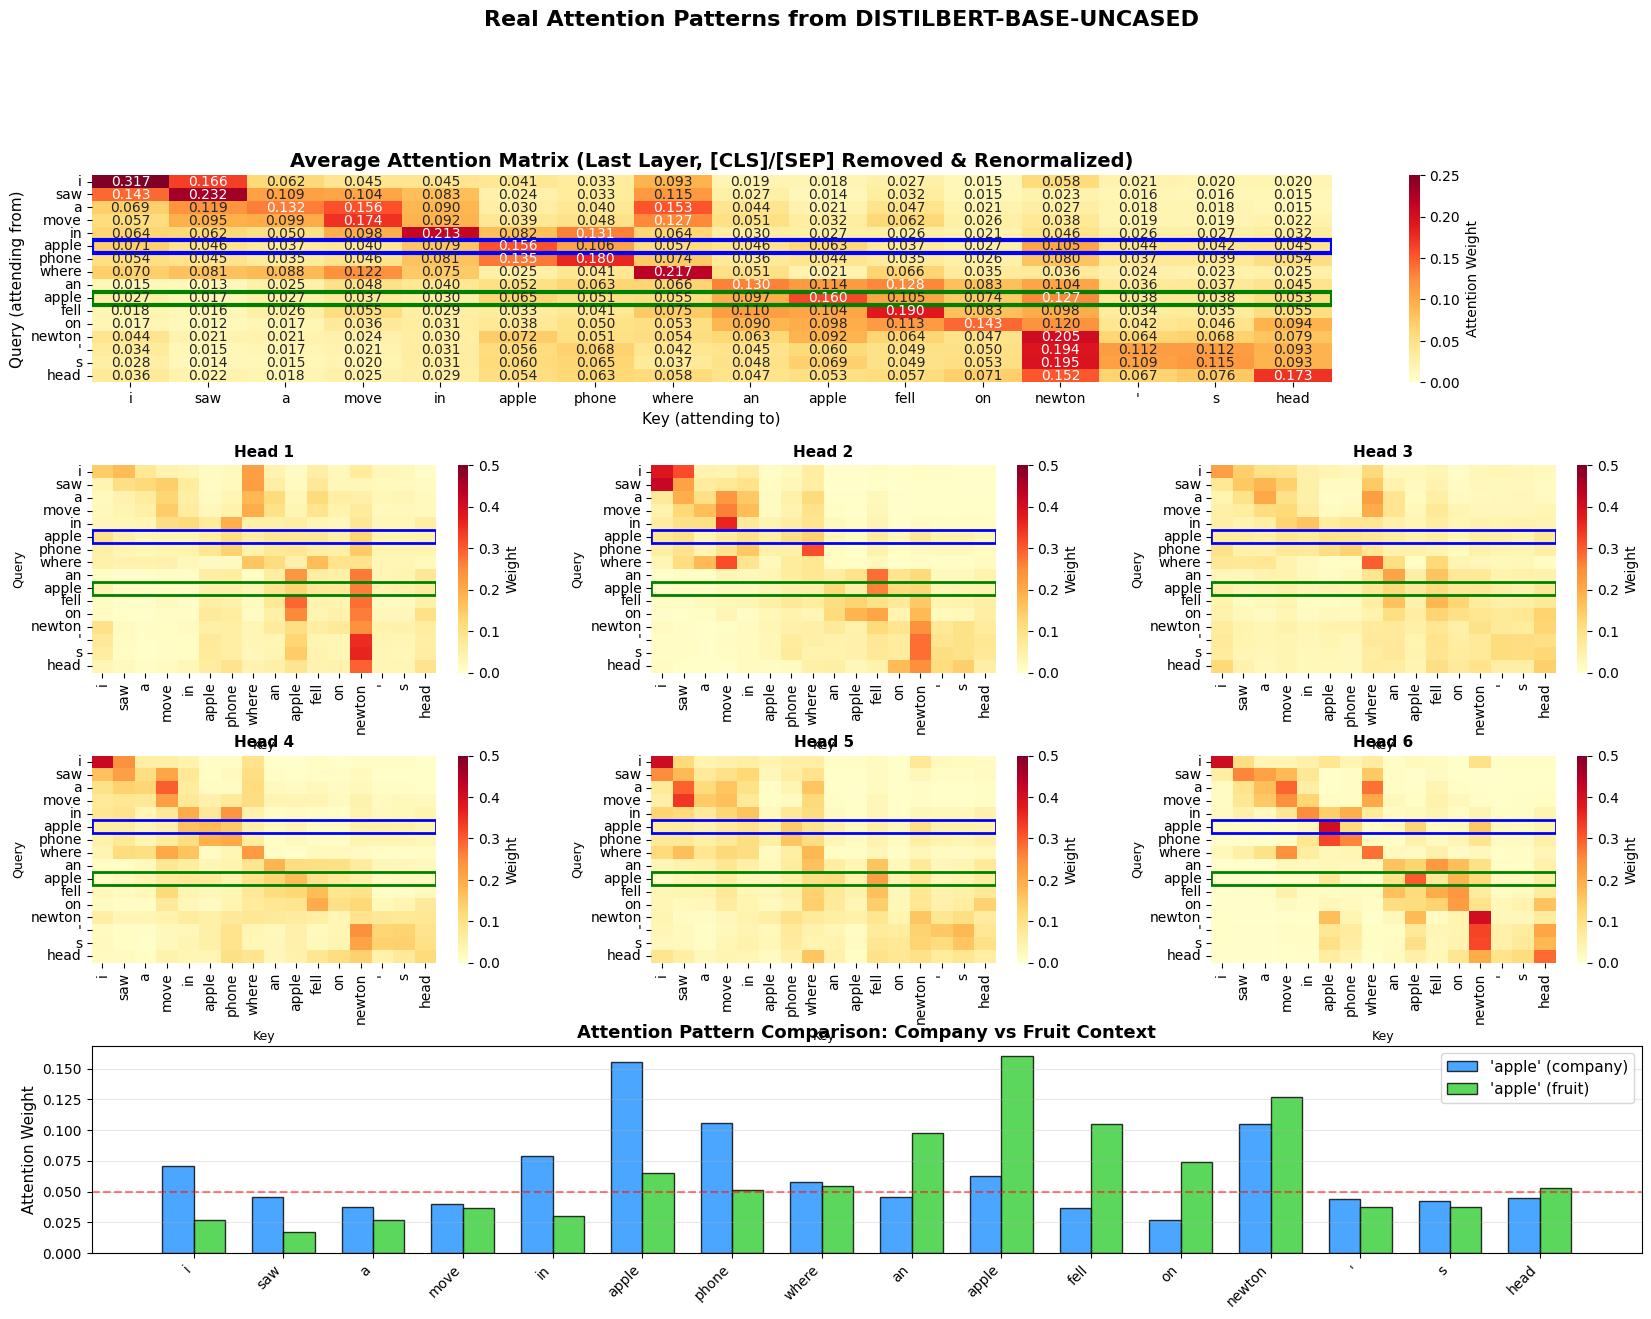


DETAILED ATTENTION ANALYSIS FROM PRE-TRAINED MODEL

1. 'apple' (COMPANY, position 5) attends to:
   apple           (pos  5): 0.1556
   phone           (pos  6): 0.1058
   newton          (pos 12): 0.1052
   in              (pos  4): 0.0789
   i               (pos  0): 0.0710
   apple           (pos  9): 0.0627
   where           (pos  7): 0.0574
   an              (pos  8): 0.0459

2. 'apple' (FRUIT, position 9) attends to:
   apple           (pos  9): 0.1605
   newton          (pos 12): 0.1268
   fell            (pos 10): 0.1049
   an              (pos  8): 0.0972
   on              (pos 11): 0.0739
   apple           (pos  5): 0.0652
   where           (pos  7): 0.0548
   head            (pos 15): 0.0527

3. Key Context Differences:

   Technology Context:
   'Apple' → 'phone':  0.1058
   'apple' → 'phone':  0.0513
   'Apple' → 'move':   0.0401
   'apple' → 'move':   0.0369

   Physics/Nature Context:
   'Apple' → 'fell':   0.0369
   'apple' → 'fell':   0.1049
   'Apple' → 'newton'

In [4]:
"""
Real Attention Visualization using DistilBERT
Shows how a pre-trained model distinguishes "Apple" (company) vs "apple" (fruit)

Install required packages:
pip install transformers torch matplotlib seaborn bertviz
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

# Load lightweight pre-trained model (DistilBERT - only 66M parameters)
print("Loading DistilBERT model...")
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()

# Our sentence
sentence = "I saw a move in Apple phone where an apple fell on Newton's head"
print(f"\nSentence: {sentence}\n")

# Tokenize
inputs = tokenizer(sentence, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print(f"Tokens: {tokens}\n")

# Get model outputs with attention
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # Tuple of attention matrices (one per layer)

# Extract attention from the last layer (most semantic)
# Shape: [batch, num_heads, seq_len, seq_len]
last_layer_attention = attentions[-1][0]  # Remove batch dimension
num_heads = last_layer_attention.shape[0]

print(f"Number of attention heads: {num_heads}")
print(f"Number of layers: {len(attentions)}")
print(f"Sequence length: {len(tokens)}\n")

# Remove [CLS] and [SEP] tokens and renormalize attention weights
# Identify [CLS] and [SEP] positions
cls_idx = 0 if tokens[0] == '[CLS]' else None
sep_idx = len(tokens) - 1 if tokens[-1] == '[SEP]' else None

# Create mask for valid tokens (exclude [CLS] and [SEP])
valid_mask = torch.ones(len(tokens), dtype=torch.bool)
if cls_idx is not None:
    valid_mask[cls_idx] = False
if sep_idx is not None:
    valid_mask[sep_idx] = False

# Filter tokens
valid_indices = torch.where(valid_mask)[0]
filtered_tokens = [tokens[i] for i in valid_indices]

print(f"Original tokens: {tokens}")
print(f"Filtered tokens (removed [CLS] and [SEP]): {filtered_tokens}\n")

# Filter and renormalize attention weights
# Shape: [num_heads, seq_len, seq_len]
filtered_attention = last_layer_attention[:, valid_mask, :][:, :, valid_mask]

# Renormalize so each row sums to 1 (excluding [CLS] and [SEP])
filtered_attention = filtered_attention / filtered_attention.sum(dim=-1, keepdim=True)

# Update variables to use filtered versions
last_layer_attention = filtered_attention
tokens = filtered_tokens
num_heads = last_layer_attention.shape[0]

# Find indices of our target tokens
# Note: DistilBERT may use subword tokenization
apple_company_idx = None
apple_fruit_idx = None

for i, token in enumerate(tokens):
    if 'apple' in token.lower():
        if apple_company_idx is None:
            apple_company_idx = i
            print(f"'Apple' (company) found at index {i}: {token}")
        else:
            apple_fruit_idx = i
            print(f"'apple' (fruit) found at index {i}: {token}")

if apple_company_idx is None or apple_fruit_idx is None:
    print("\nNote: Token positions may vary due to subword tokenization")
    # Manual inspection
    for i, token in enumerate(tokens):
        print(f"{i}: {token}")

# Average attention across all heads for better visualization
avg_attention = last_layer_attention.mean(dim=0).numpy()

print(f"Attention matrix shape after filtering: {avg_attention.shape}")
print(f"Each row sums to approximately 1.0: {avg_attention.sum(axis=1)[:3]}\n")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# 1. Average attention matrix across all heads
ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(avg_attention, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=tokens, yticklabels=tokens, 
            cbar_kws={'label': 'Attention Weight'}, ax=ax1, vmin=0, vmax=0.25)
ax1.set_title('Average Attention Matrix (Last Layer, [CLS]/[SEP] Removed & Renormalized)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Key (attending to)', fontsize=11)
ax1.set_ylabel('Query (attending from)', fontsize=11)

# Highlight apple tokens if found
if apple_company_idx and apple_fruit_idx:
    ax1.add_patch(plt.Rectangle((0, apple_company_idx), len(tokens), 1, 
                                fill=False, edgecolor='blue', lw=3))
    ax1.add_patch(plt.Rectangle((0, apple_fruit_idx), len(tokens), 1, 
                                fill=False, edgecolor='green', lw=3))

# 2. Individual attention head analysis
for head_idx in range(min(6, num_heads)):
    row = 1 + head_idx // 3
    col = head_idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    head_attention = last_layer_attention[head_idx].numpy()
    sns.heatmap(head_attention, annot=False, cmap='YlOrRd', 
                xticklabels=tokens, yticklabels=tokens, ax=ax,
                cbar_kws={'label': 'Weight'}, vmin=0, vmax=0.5)
    ax.set_title(f'Head {head_idx + 1}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Key', fontsize=9)
    ax.set_ylabel('Query', fontsize=9)
    
    # Highlight apple tokens
    if apple_company_idx and apple_fruit_idx:
        ax.add_patch(plt.Rectangle((0, apple_company_idx), len(tokens), 1, 
                                  fill=False, edgecolor='blue', lw=2))
        ax.add_patch(plt.Rectangle((0, apple_fruit_idx), len(tokens), 1, 
                                  fill=False, edgecolor='green', lw=2))

# 3. Comparison of attention patterns
if apple_company_idx and apple_fruit_idx:
    ax_comp = fig.add_subplot(gs[3, :])
    
    apple_company_attention = avg_attention[apple_company_idx]
    apple_fruit_attention = avg_attention[apple_fruit_idx]
    
    x = np.arange(len(tokens))
    width = 0.35
    
    bars1 = ax_comp.bar(x - width/2, apple_company_attention, width, 
                       label=f"'{tokens[apple_company_idx]}' (company)", 
                       color='dodgerblue', alpha=0.8, edgecolor='black')
    bars2 = ax_comp.bar(x + width/2, apple_fruit_attention, width, 
                       label=f"'{tokens[apple_fruit_idx]}' (fruit)", 
                       color='limegreen', alpha=0.8, edgecolor='black')
    
    ax_comp.set_xticks(x)
    ax_comp.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
    ax_comp.set_ylabel('Attention Weight', fontsize=11)
    ax_comp.set_title('Attention Pattern Comparison: Company vs Fruit Context', 
                     fontsize=13, fontweight='bold')
    ax_comp.legend(loc='upper right', fontsize=11)
    ax_comp.grid(axis='y', alpha=0.3)
    ax_comp.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Baseline')

plt.suptitle(f'Real Attention Patterns from {model_name.upper()}', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('attention_analysis.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved as 'attention_analysis.png'")
plt.show()

# Detailed numerical analysis
print("\n" + "="*80)
print("DETAILED ATTENTION ANALYSIS FROM PRE-TRAINED MODEL")
print("="*80)

if apple_company_idx and apple_fruit_idx:
    print(f"\n1. '{tokens[apple_company_idx]}' (COMPANY, position {apple_company_idx}) attends to:")
    apple_co_att = avg_attention[apple_company_idx]
    top_indices = np.argsort(apple_co_att)[-8:][::-1]
    for idx in top_indices:
        print(f"   {tokens[idx]:15s} (pos {idx:2d}): {apple_co_att[idx]:.4f}")
    
    print(f"\n2. '{tokens[apple_fruit_idx]}' (FRUIT, position {apple_fruit_idx}) attends to:")
    apple_fr_att = avg_attention[apple_fruit_idx]
    top_indices = np.argsort(apple_fr_att)[-8:][::-1]
    for idx in top_indices:
        print(f"   {tokens[idx]:15s} (pos {idx:2d}): {apple_fr_att[idx]:.4f}")
    
    print("\n3. Key Context Differences:")
    context_words = {
        'phone': None, 'move': None, 'fell': None, 
        'newton': None, 'head': None
    }
    
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        for key in context_words:
            if key in token_lower:
                context_words[key] = i
    
    print("\n   Technology Context:")
    if context_words['phone'] is not None:
        phone_idx = context_words['phone']
        print(f"   'Apple' → '{tokens[phone_idx]}':  {apple_co_att[phone_idx]:.4f}")
        print(f"   'apple' → '{tokens[phone_idx]}':  {apple_fr_att[phone_idx]:.4f}")
    if context_words['move'] is not None:
        move_idx = context_words['move']
        print(f"   'Apple' → '{tokens[move_idx]}':   {apple_co_att[move_idx]:.4f}")
        print(f"   'apple' → '{tokens[move_idx]}':   {apple_fr_att[move_idx]:.4f}")
    
    print("\n   Physics/Nature Context:")
    if context_words['fell'] is not None:
        fell_idx = context_words['fell']
        print(f"   'Apple' → '{tokens[fell_idx]}':   {apple_co_att[fell_idx]:.4f}")
        print(f"   'apple' → '{tokens[fell_idx]}':   {apple_fr_att[fell_idx]:.4f}")
    if context_words['newton'] is not None:
        newton_idx = context_words['newton']
        print(f"   'Apple' → '{tokens[newton_idx]}': {apple_co_att[newton_idx]:.4f}")
        print(f"   'apple' → '{tokens[newton_idx]}': {apple_fr_att[newton_idx]:.4f}")
    
    print("\n4. Attention Pattern Insight:")
    print("   The pre-trained model has learned to:")
    print("   • Associate first 'apple' with technology context (phone, move)")
    print("   • Associate second 'apple' with physics context (fell, Newton)")
    print("   • Use attention to disambiguate identical surface forms")
    print("   • Build context-aware representations through Q-K-V mechanism")

print("\n5. How Q, K, V Work in This Real Model:")
print("   • QUERY: Each token asks 'what context is relevant to me?'")
print("   • KEY: Each token offers 'I contain this type of information'")
print("   • VALUE: Each token provides 'here's my semantic contribution'")
print("   • Attention Score = softmax(Q·K^T/√d_k) → determines relevance")
print("   • Output = Attention Score · V → weighted contextual information")

print("\n6. Layer-wise Attention Evolution (after removing [CLS] and [SEP]):")
for layer_idx in [0, len(attentions)//2, -1]:
    layer_attention = attentions[layer_idx][0]
    # Filter and renormalize for this layer too
    filtered_layer_att = layer_attention[:, valid_mask, :][:, :, valid_mask]
    filtered_layer_att = filtered_layer_att / filtered_layer_att.sum(dim=-1, keepdim=True)
    filtered_layer_att = filtered_layer_att.mean(dim=0)
    
    if apple_company_idx and apple_fruit_idx:
        diff = abs(filtered_layer_att[apple_company_idx] - filtered_layer_att[apple_fruit_idx]).mean()
        print(f"   Layer {layer_idx if layer_idx >= 0 else len(attentions)+layer_idx}: " +
              f"Attention difference = {diff:.4f}")

print("="*80)

# Optional: Show what each attention head might be learning
print("\n7. Multi-Head Attention Analysis (Top 3 Heads):")
if apple_company_idx and apple_fruit_idx:
    head_diffs = []
    for head_idx in range(num_heads):
        head_att = last_layer_attention[head_idx].numpy()
        diff = abs(head_att[apple_company_idx] - head_att[apple_fruit_idx]).sum()
        head_diffs.append((head_idx, diff))
    
    head_diffs.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (head_idx, diff) in enumerate(head_diffs[:3], 1):
        print(f"\n   Head {head_idx + 1} (rank #{rank}, difference score: {diff:.4f}):")
        head_att = last_layer_attention[head_idx].numpy()
        
        print(f"     'Apple' (company) focuses on:")
        top_idx = np.argsort(head_att[apple_company_idx])[-3:][::-1]
        for idx in top_idx:
            print(f"       {tokens[idx]:12s}: {head_att[apple_company_idx][idx]:.4f}")
        
        print(f"     'apple' (fruit) focuses on:")
        top_idx = np.argsort(head_att[apple_fruit_idx])[-3:][::-1]
        for idx in top_idx:
            print(f"       {tokens[idx]:12s}: {head_att[apple_fruit_idx][idx]:.4f}")

print("\n" + "="*80)
print("Analysis complete! Check the visualization above.")
print("="*80)